This notebook compares deep learning approaches for the Quora duplicate question detection task. The primary goal was to assess whether transformer-based models outperform traditional models when trained on an augmented dataset that includes additional positive samples generated with a language model.

Two model families were evaluated:

LSTM: A recurrent neural network trained on preprocessed sequences formed from question pairs. The model used a vocabulary size of 15,000 and a maximum sequence length of 60 tokens.

DistilBERT: A transformer-based model fine-tuned end-to-end on the same training data. Fine-tuning was performed over 3 epochs with batch size 16, and evaluation was carried out on both the train and held-out test set.

Evaluation metrics included accuracy, F1-score, and log loss for both models.

# Imports

In [9]:
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from src.models.lstm_trainer import LSTMTrainer
from src.models.bert_finetuner import BertFineTuner
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [3]:
# Load augmented + original training data
full_train_df = pd.read_csv("../data/processed/full_train_augmented.csv")

# Clean NaNs and filter label if needed
full_train_df = full_train_df.dropna(subset=['question1', 'question2', 'is_duplicate'])

# Create text column for LSTM (you can also try joining Q1 + Q2 for now)
full_train_df["cleaned_text"] = full_train_df["question1"].astype(str) + " [SEP] " + full_train_df["question2"].astype(str)

# Optional: Use a held-out test set
test_df = pd.read_csv("../data/processed/quora_test_with_bert_sim.csv")
test_df = test_df.dropna(subset=["question1", "question2", "is_duplicate"])
test_df["cleaned_text"] = test_df["question1"].astype(str) + " [SEP] " + test_df["question2"].astype(str)

# Optional: Smaller train_df for quick tests (if you're using .train_on_mini)
#train_df = full_train_df.sample(20000, random_state=42)  # Or full_train_df


# LSTM Model: Sequence Preparation and Training

In [5]:
# Initialize LSTM trainer with hyperparameters
lstm_trainer = LSTMTrainer(max_num_words=15000, max_seq_len=60)

# Prepare sequences from the full training dataframe
X, y = lstm_trainer.prepare_sequences(full_train_df, col1="question1", col2="question2")

# Split data into train, validation, and test sets (stratified by class)
X_train, X_val, X_test, y_train, y_val, y_test = lstm_trainer.train_val_test_split(X, y)

# Build and compile the LSTM model
lstm_trainer.build_model()

# Train the LSTM model
lstm_trainer.train(
    X_train, y_train, 
    X_val, y_val, 
    epochs=5, batch_size=128
)

# Evaluate the model on the test set
lstm_trainer.evaluate(X_test, y_test)

Epoch 1/5


c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1833/1833 ━━━━━━━━━━━━━━━━━━━━ 145s 77ms/step - accuracy: 0.7312 - loss: 0.5338 - val_accuracy: 0.7649 - val_loss: 0.4826
Epoch 2/5
1833/1833 ━━━━━━━━━━━━━━━━━━━━ 142s 78ms/step - accuracy: 0.7888 - loss: 0.4418 - val_accuracy: 0.7770 - val_loss: 0.4642
Epoch 3/5
1833/1833 ━━━━━━━━━━━━━━━━━━━━ 148s 81ms/step - accuracy: 0.8244 - loss: 0.3804 - val_accuracy: 0.7808 - val_loss: 0.4652
Epoch 4/5
1833/1833 ━━━━━━━━━━━━━━━━━━━━ 143s 78ms/step - accuracy: 0.8579 - loss: 0.3181 - val_accuracy: 0.7753 - val_loss: 0.5001
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step
F1-score: 0.6843834330634753
Log loss: 0.462216912393905
Confusion matrix:
 [[26272  4254]
 [ 6506 11666]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83     30526
           1       0.73      0.64      0.68     18172

    accuracy                           0.78     48698
   macro avg       0.77      0.75      0.76     48698
weighted avg       0.78      0.78  

{'f1': 0.6843834330634753, 'logloss': 0.462216912393905}

# BERT/DistilBERT Fine-tuning and Evaluation

In [ ]:
# Initialize the fine-tuner for a transformer model
finetuner = BertFineTuner(model_ckpt="distilbert-base-uncased")

# Fine-tune the transformer model on the full training data
results = finetuner.train_full(full_train_df, test_df, n_epochs=3, batch_size=16)

In [4]:
# Evaluation
model = AutoModelForSequenceClassification.from_pretrained("distilbert-full")
tokenizer = AutoTokenizer.from_pretrained("distilbert-full")

finetuner = BertFineTuner(model_ckpt="distilbert-base-uncased")
finetuner.model = model 

train_ds = finetuner.df_to_hfds(full_train_df)
train_tok = train_ds.map(finetuner.tokenize_batch, batched=True, remove_columns=["text"])

args = TrainingArguments(
    output_dir="tmp-eval-train",
    per_device_eval_batch_size=16,
    logging_dir="./logs"
)

trainer = Trainer(
    model=finetuner.model,
    args=args,
    eval_dataset=train_tok,
    tokenizer=finetuner.tokenizer,
    data_collator=finetuner.collator,
    compute_metrics=finetuner.metrics
)

results_train = trainer.evaluate()
print("Evaluation on full TRAIN set:")
print(results_train)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/324649 [00:00<?, ? examples/s]

C:\Users\allen\AppData\Local\Temp\ipykernel_17196\1890015449.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation on full TRAIN set:
{'eval_loss': 0.09895668923854828, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.9673185501880492, 'eval_log_loss': 0.09895668123996684, 'eval_f1': 0.9569402845756122, 'eval_runtime': 610.0809, 'eval_samples_per_second': 532.141, 'eval_steps_per_second': 33.26}


Evaluation on full TRAIN set:
{'eval_loss': 0.09895668923854828, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.9673185501880492, 'eval_log_loss': 0.09895668123996684, 'eval_f1': 0.9569402845756122, 'eval_runtime': 605.151, 'eval_samples_per_second': 536.476, 'eval_steps_per_second': 33.53}

In [5]:
finetuner.model.save_pretrained("../src/models/distilbert_finetuned")
finetuner.tokenizer.save_pretrained("../src/models/distilbert_finetuned")

('../src/models/distilbert_finetuned\\tokenizer_config.json',
 '../src/models/distilbert_finetuned\\special_tokens_map.json',
 '../src/models/distilbert_finetuned\\vocab.txt',
 '../src/models/distilbert_finetuned\\added_tokens.json',
 '../src/models/distilbert_finetuned\\tokenizer.json')

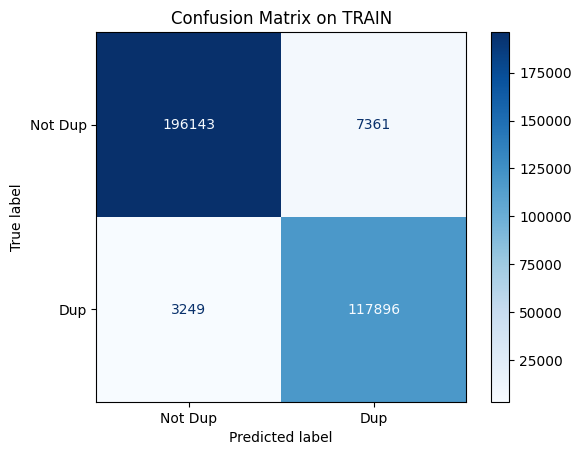

              precision    recall  f1-score   support

     Not Dup       0.98      0.96      0.97    203504
         Dup       0.94      0.97      0.96    121145

    accuracy                           0.97    324649
   macro avg       0.96      0.97      0.97    324649
weighted avg       0.97      0.97      0.97    324649



In [11]:
# Prediction
preds_output = trainer.predict(train_tok)  
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# Matrix and classification report
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Dup", "Dup"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on TRAIN")  # або TEST
plt.show()

print(classification_report(y_true, y_pred, target_names=["Not Dup", "Dup"]))
results_test = trainer.evaluate(eval_dataset=test_tok)

# test_df for evaluation

Map:   0%|          | 0/80858 [00:00<?, ? examples/s]

C:\Users\allen\AppData\Local\Temp\ipykernel_17196\402863424.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


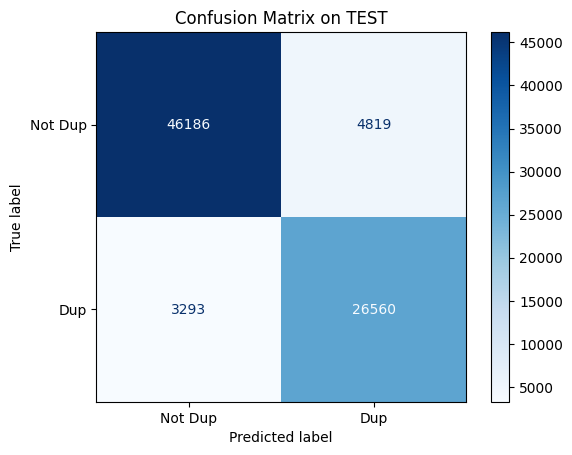

              precision    recall  f1-score   support

     Not Dup       0.93      0.91      0.92     51005
         Dup       0.85      0.89      0.87     29853

    accuracy                           0.90     80858
   macro avg       0.89      0.90      0.89     80858
weighted avg       0.90      0.90      0.90     80858



Test Accuracy: 0.899675975166341
Test F1: 0.8675202508492291
Test LogLoss: 0.33365573444021235
Evaluation on full test set:
{'eval_loss': 0.3336557149887085, 'eval_model_preparation_time': 0.0022, 'eval_accuracy': 0.899675975166341, 'eval_log_loss': 0.33365573444021235, 'eval_f1': 0.8675202508492291, 'eval_runtime': 158.9823, 'eval_samples_per_second': 508.597, 'eval_steps_per_second': 31.79}


In [10]:
def to_dataset(df):
    df = df.rename(columns={"is_duplicate": "labels"}).copy()
    df["text"] = df["question1"].fillna("") + " [SEP] " + df["question2"].fillna("")
    return Dataset.from_pandas(df[["text", "labels"]])

def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=64)

test_dataset = to_dataset(test_df)
test_tok = test_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=finetuner.metrics, 
    data_collator=finetuner.collator,
    args=TrainingArguments(
        output_dir="tmp-eval-test",
        per_device_eval_batch_size=16,
        logging_dir="./logs"
    )
)
# Prediction
preds_output = trainer.predict(test_tok)  
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# Matrix and classification report
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Dup", "Dup"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on TEST")  
plt.show()

print(classification_report(y_true, y_pred, target_names=["Not Dup", "Dup"]))
results_test = trainer.evaluate(eval_dataset=test_tok)

print("Test Accuracy:", results_test.get("eval_accuracy"))
print("Test F1:", results_test.get("eval_f1"))
print("Test LogLoss:", results_test.get("eval_log_loss"))
print("Evaluation on full test set:")
print(results_test)


Test Accuracy: 0.899675975166341
Test F1: 0.8675202508492291
Test LogLoss: 0.33365573444021235
Evaluation on full test set:
{'eval_loss': 0.3336557149887085, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.899675975166341, 'eval_log_loss': 0.33365573444021235, 'eval_f1': 0.8675202508492291, 'eval_runtime': 148.5264, 'eval_samples_per_second': 544.402, 'eval_steps_per_second': 34.028}

In [ ]:
# Prepare results for DataFrame
results_train = {
    "Set": "Train",
    "Accuracy": results_train["eval_accuracy"],
    "F1": results_train["eval_f1"],
    "LogLoss": results_train["eval_log_loss"]
}

results_test = {
    "Set": "Test",
    "Accuracy": results_test["eval_accuracy"],
    "F1": results_test["eval_f1"],
    "LogLoss": results_test["eval_log_loss"],
}

df_results = pd.DataFrame([results_train, results_test])
print(df_results)

     Set  Accuracy       F1   LogLoss
0  Train  0.967319  0.95694  0.098957
1   Test  0.899676  0.86752  0.333656


The DistilBERT model significantly outperformed the LSTM model across all metrics. On the test set, DistilBERT achieved an F1-score of 0.87, compared to 0.68 from the LSTM model. This confirms that transformers, even lightweight versions like DistilBERT, are more effective in capturing semantic similarity between questions than LSTM-based architectures, particularly on augmented data.

Despite the data imbalance being partially addressed through augmentation, the relatively modest size (~2,700 new samples) may still limit the generalization performance, especially for simpler models like LSTM. Additionally, the overfitting observed in DistilBERT’s high train accuracy (96.7%) compared to test accuracy (89.9%) suggests the model could benefit from regularization or further data augmentation.

Overall, transformer-based fine-tuning proves to be a robust choice for duplicate question detection in this context.